In [1]:
import json
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from shap import DeepExplainer
from sklearn.model_selection import KFold

sys.path.insert(0, "/mnt/c/Users/nick/Desktop/corsello_lab/refract")
import argparse
import logging

from refract.datasets import PrismDataset
from refract.losses import lambdaLoss
from refract.metrics import get_stringdb_network_interactions
from refract.models import FeedForwardNet
from refract.ranking_trainers import NNRankerTrainer

from scipy.stats import pearsonr

/home/nphillips/miniconda3/envs/corlab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(level="INFO")

NUM_FEATURES = 100
SLATE_LENGTH = 10
NUM_EPOCHS = 50
BATCH_SIZE = 512

In [3]:
response_test = pd.read_csv("dfs/response_test.csv")

In [4]:
feature_test = pd.read_csv("dfs/feature_test.csv", index_col=0)

In [5]:
compound_name = "caramiphen"
feature_importance_path = f"/mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230607_validate_performance/feature_importance_paths/{compound_name}.csv"
feature_importance_df = pd.read_csv(feature_importance_path)

In [6]:
import pickle
with open("train_feature_transformer.pkl", "rb") as f:
    feature_transformer = pickle.load(f)

In [7]:
ds_test = PrismDataset(
    response_test,
    feature_test,
    feature_importance_df,
    top_k_features=NUM_FEATURES,
    slate_length=SLATE_LENGTH,
    feature_transformer=feature_transformer,
)


In [8]:
# load model
model_path = "models/caramiphen.pt"
model = FeedForwardNet(NUM_FEATURES)
model.load_state_dict(torch.load(model_path))
model.to("cuda")
model.eval()

FeedForwardNet(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = NNRankerTrainer(model, optimizer)

In [10]:
test_ccle_names, test_preds, test_trues, test_corr = trainer.eval(ds_test)
print("R test: ", test_corr)

R test:  (0.4833141844508934, 1.1696758218448958e-07)


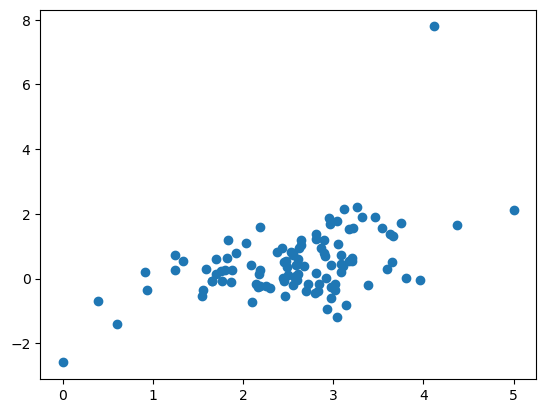

In [11]:
plt.scatter(test_trues, test_preds)

In [12]:
# in contrast
mts_preds = pd.read_csv(f"mts_pred_true/{compound_name}.csv", index_col=0)

In [13]:
in_test_set = mts_preds.loc[mts_preds.index.isin(test_ccle_names), :]

In [14]:
len(in_test_set)

79

In [15]:
in_test_set.head(3)

,true,preds
BICR31_UPPER_AERODIGESTIVE_TRACT,0.005059,-0.018977
BC3C_URINARY_TRACT,-0.227883,-0.010834
KP4_PANCREAS,0.175196,-0.001526


In [16]:
corr = pearsonr(in_test_set["true"].values, in_test_set["preds"].values)
print("MTS corr: ", corr)

MTS corr:  (-0.30733107495286666, 0.005867497784337691)


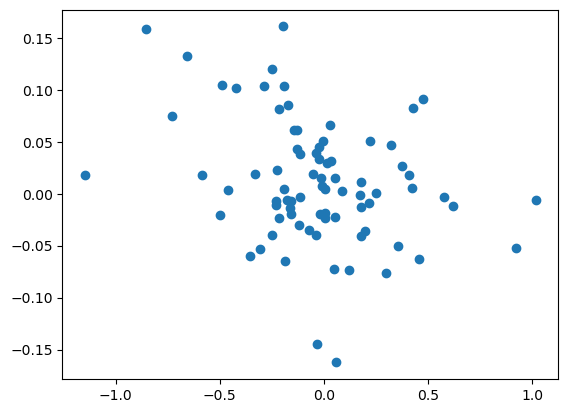

In [17]:
plt.scatter(in_test_set["true"].values, in_test_set["preds"].values)